<a href="https://colab.research.google.com/github/rvernica/notebook/blob/main/Shallow_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

In [ ]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)


def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

In [ ]:
# X, Y = load_planar_dataset()

In [ ]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)

    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]

    return (n_x, n_h, n_y)

In [ ]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    W1 = np.random.randn(n_h, n_x) * .01 # 4 x n
    b1 = np.zeros((n_h, 1))              # 4 x 1
    W2 = np.random.randn(n_y, n_h) * .01 # 1 x 4
    b2 = np.zeros((n_y, 1))              # 1 x 1

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [ ]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)

    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = W1 @ X + b1  # 4 x n @ n x m = 4 x m
    A1 = np.tanh(Z1)  # 4 x m
    Z2 = W2 @ A1 + b2 # 1 x 4 @ 4 x m = 1 x m
    A2 = sigmoid(Z2)  # 1 x m

    assert(A2.shape == (1, X.shape[1]))

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

In [ ]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)

    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost given equation (13)

    """

    m = Y.shape[1] # number of examples

    logprobs = Y * np.log(A2) + (1 - Y) * np.log(1 - A2)
    cost = -1 / m * np.sum(logprobs)

    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect.
                                    # E.g., turns [[17]] into 17

    return cost

In [ ]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.

    Arguments:
    parameters -- python dictionary containing our parameters
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]

    W1 = parameters["W1"] # 4 x n
    W2 = parameters["W2"] # 1 x 4

    A1 = cache["A1"] # 4 x m
    A2 = cache["A2"] # 1 x m

    dZ2 = A2 - Y # 1 x m
    dW2 = 1 / m * dZ2 @ A1.T # 1 x m @ m x 4 = 1 x 4
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True) # 1 x 1
    dZ1 = W2.T @ dZ2 * (1 - np.power(A1, 2)) # 4 x 1 @ 1 x m = 4 x m
    dW1 = 1 / m * dZ1 @ X.T # 4 x m @ m x n = 4 x n
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True) # 4 x 1

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

In [ ]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above

    Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients

    Returns:
    parameters -- python dictionary containing your updated parameters
    """
    W1 = copy.deepcopy(parameters["W1"])
    b1 = parameters["b1"]
    W2 = copy.deepcopy(parameters["W2"])
    b2 = parameters["b2"]

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [ ]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(0, num_iterations):

        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)

        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)

        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [ ]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X

    Arguments:
    parameters -- python dictionary containing your parameters
    X -- input data of size (n_x, m)

    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """

    A2, cache = forward_propagation(X, parameters)
    predictions = A2 > .5

    return predictions

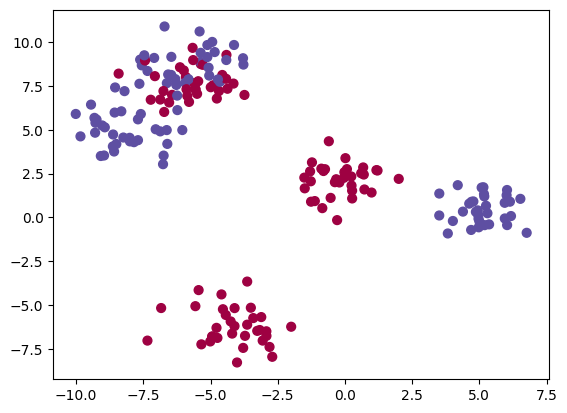

In [ ]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

# dataset = "noisy_circles"
# dataset = "noisy_moons"
dataset = "blobs"
# dataset = "gaussian_quantiles"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Cost after iteration 0: 0.693080
Cost after iteration 1000: 0.324641
Cost after iteration 2000: 0.323384
Cost after iteration 3000: 0.322701
Cost after iteration 4000: 0.322766
Cost after iteration 5000: 0.322732
Cost after iteration 6000: 0.322861
Cost after iteration 7000: 0.322675
Cost after iteration 8000: 0.322675
Cost after iteration 9000: 0.322656


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

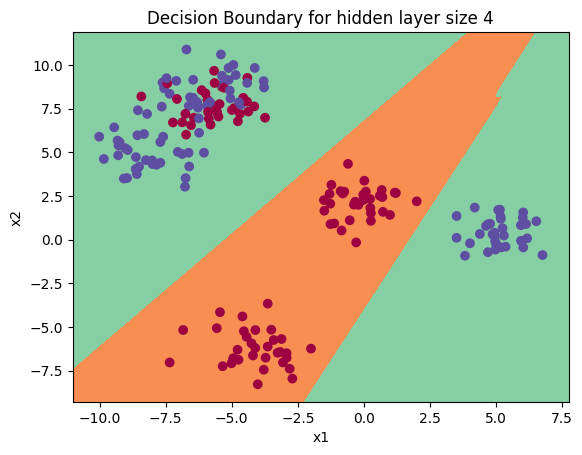

In [ ]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [ ]:
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 83%


/tmp/ipython-input-88-874434534.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')
